In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pyrealm.pmodel import PModel, PModelEnvironment, SubdailyPModel, AcclimationModel
#from pyrealm.pmodel.functions import calc_ftemp_arrh, calc_ftemp_kphio
#from pyrealm.pmodel.subdaily import memory_effect
from pyrealm.pmodel.optimal_chi import OptimalChiPrentice14
from sklearn.metrics import mean_squared_error, r2_score


In [4]:

# remember to change the path of your file

start_year = 2000
end_year = 2014

datetime_subdaily=np.arange(datetime(start_year, 1, 1, 0, 00),
              datetime(end_year,1,1,0,0),
              np.timedelta64(30, "m"))

# site_file = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_CH-Lae_FLUXNET2015_FULLSET_2004-2014_1-4/FLX_CH-Lae_FLUXNET2015_FULLSET_HH_2004-2014_1-4.csv"
site_file = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/FLX_IT-Ren_FLUXNET2015_FULLSET_HH_1998-2013_1-4.csv"
# site_file = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_CH-Dav_FLUXNET2015_FULLSET_1997-2014_1-4/FLX_CH-Dav_FLUXNET2015_FULLSET_HH_1997-2014_1-4.csv"

ds = pd.read_csv(site_file)
# extract site name from the file name CH-Dav
site_name = site_file.split("/")[-1].split("_")[1]


# filter ds by ds["TIMESTAMP_START"] with format YYYMMDDHHSS to start_year till 1.1. 00:00h of end_year
ds["TIMESTAMP_START"] = pd.to_datetime(ds["TIMESTAMP_START"], format='%Y%m%d%H%M')
ds = ds[(ds["TIMESTAMP_START"] >= datetime(start_year, 1, 1, 0, 00)) & (ds["TIMESTAMP_START"] < datetime(end_year, 1, 1, 0, 00))]
ds = ds.set_index("TIMESTAMP_START")

# Extract the key half hourly timestep variables as numpy arrays
site_temp = ds.loc[:, 'TA_F_MDS'] # daily temperature, unit degree (°C)
site_temp[site_temp < -25] = np.nan
site_swin = ds.loc[:, 'SW_IN_F_MDS']  # shortwave radiation, unit W/m2
site_ppfd = ds.loc[:, 'PPFD_IN'] # Shortwave radiation (W/m²) × 0.50 -> PAR (W/m²) × 4.6 -> PPFD (umol/m²/s)
site_vpd = ds.loc[:, 'VPD_F_MDS'] * 100  # vpd, unit: hPa converted to Pa
site_co2 = ds.loc[:, 'CO2_F_MDS']  # CO2, unit ppm
site_patm = ds.loc[:, 'PA_F'] * 1000  # site pressure, unit kPa converted to Pa
site_prep = ds.loc[:,'P_F']
site_gpp = ds.loc[:,'GPP_DT_VUT_USTAR50']  # GPP, unit: gC/m2/d


#site_fapar = ds.loc[:, 'FPAR']  # fapar
#ds.columns
#site_ppfd = ds.loc[:, 'PPFD_IN'] 
site_ppfd.max()
mod_files =  "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/IT-Ren_MOD15A2H_Fpar_500m_1997-12-12_2014-01-20.xlsx" 
myd_files = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_IT-Ren_FLUXNET2015_FULLSET_1998-2013_1-4/IT-Ren_MYD15A2H_Fpar_500m_1997-12-12_2014-01-20.xlsx"

# mod_files = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_CH-Dav_FLUXNET2015_FULLSET_1997-2014_1-4/CH-Dav_MOD15A2H_Lai_500m_1996-12-12_2015-01-20.xlsx"
# myd_files = "/scratch/c7071034/DATA/Fluxnet2015/Alps/FLX_CH-Dav_FLUXNET2015_FULLSET_1997-2014_1-4/CH-Dav_MYD15A2H_Lai_500m_1996-12-12_2015-01-20.xlsx" 
# Process MOD and MYD files
dfs_modis = []
for file_path in [mod_files, myd_files]:
    df = pd.read_excel(file_path)[["calendar_date", "value"]].assign(
        value=lambda x: x["value"] * 0.0001  # TODO: scale Lai diffently
    )  # sclaing factor from user guide: https://lpdaac.usgs.gov/documents/103/MOD13_User_Guide_V6.pdf
    file_parts = file_path.split("/")[-1]
    file_parts2 = file_parts.split("_")[2:6]
    if file_parts2[0] == "250m":
        file_type = "_".join(file_parts2)
    else:
        file_type = "_".join(file_parts2[:-1])
    df.rename(columns={"value": file_type}, inplace=True)
    dfs_modis.append(df)

# Merge dataframes based on 'calendar_date'
df_modis = dfs_modis[0]
for df in dfs_modis[1:]:
    df_modis = pd.merge(
        df_modis, df, on="calendar_date", how="outer", suffixes=("_x", "_y")
    )

for column in df_modis.columns:
    if column.endswith("_x"):
        base_column = column[:-2]  # Remove suffix '_x'
        if base_column + "_y" in df_modis.columns:
            df_modis[column].fillna(df_modis[base_column + "_y"], inplace=True)
            df_modis.drop(columns=[base_column + "_y"], inplace=True)
            df_modis.rename(columns={column: base_column}, inplace=True)

df_modis.sort_values(by="calendar_date", inplace=True)
df_modis.reset_index(drop=True, inplace=True)
df_modis["calendar_date"] = pd.to_datetime(df_modis["calendar_date"])
df_modis.set_index("calendar_date", inplace=True)
# Interpolation
subdaily_series = pd.Series(index=datetime_subdaily, dtype=float)

# Reindex with interpolation
site_fapar = df_modis[df_modis.columns[0]].reindex(
    subdaily_series.index.union(df_modis.index)
).interpolate("time").reindex(subdaily_series.index)
site_fapar = site_fapar*100 # 100 due to MODIS scaling factor, and 100 to convert to percent
#clip to zero 
site_vpd.values[site_vpd.values < 0] = 0
site_ppfd.values[site_ppfd.values < 0] = 0
# site_fapar.max()

pyrealm/2539382464.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pyrealm/2539382464.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




pyrealm/pmodel.py:409: UserWarning: 
    Pyrealm 2.0.0 uses a new default for the quantum yield of photosynthesis (phi0=1/8).
    You may need to change settings to duplicate results from pyrealm 1.0.0.
            


PModelEnvironment(shape=(245472,))
Attr           Mean       Min       Max    NaN  Units
---------  --------  --------  --------  -----  ------------
tc             4.61    -19.02     27         0  °C
vpd          279.25      0      3034.8       0  Pa
co2          374.8     330.01    439.73      0  ppm
patm       82060.8   78474     84266         0  Pa
fapar          0.51      0         0.95   2304  -
ppfd         271.84      0      2199.1       0  µmol m-2 s-1
ca            30.75     26.86     35.63      0  Pa
gammastar      1.25      0.24      3.94      0  Pa
kmm           13.42      1.37     77.97      0  Pa
ns_star        1.81      0.96      4.61      0  -


pyrealm/pmodel.py:409: UserWarning: 
    Pyrealm 2.0.0 uses a new default for the quantum yield of photosynthesis (phi0=1/8).
    You may need to change settings to duplicate results from pyrealm 1.0.0.
            


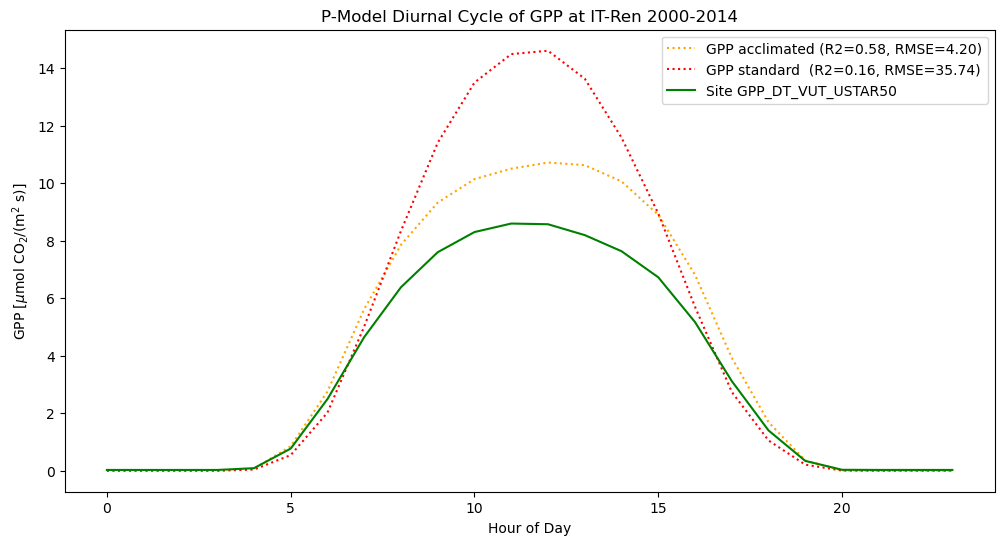

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

gC_to_mumol = 0.0833  # Conversion: gC → µmol CO₂

# Create environment with all inputs
env = PModelEnvironment(
    tc=site_temp.values,
    co2=site_co2.values,
    patm=site_patm.values,
    vpd=site_vpd.values,
    fapar=site_fapar.values,
    ppfd=site_ppfd.values
)

# Run P Model
model = PModel(env)

pmodel_subdaily_std = model.gpp*gC_to_mumol

# Prepare the photosynthetic environment with all inputs
subdaily_env = PModelEnvironment(
    tc=site_temp.values,
    vpd=site_vpd.values,
    co2=site_co2.values,
    patm=site_patm.values,
    ppfd=site_ppfd.values,
    fapar=site_fapar.values,
)
subdaily_env.summarize()

datetime_subdaily_df = site_temp.index
datetime_subdaily = pd.to_datetime(datetime_subdaily_df).to_numpy()
# Set acclimation window parameters
window_cent = 13
half_wdth = 92
acclim_model = AcclimationModel(datetime_subdaily, allow_holdover=True, alpha=1 / 37)
acclim_model.set_window(
    window_center=np.timedelta64(window_cent, "h"),
    half_width=np.timedelta64(half_wdth, "m"),
)

# Fit the P Model with fast and slow responses
pmodel_subdaily = SubdailyPModel(
    env=subdaily_env,
    acclim_model=acclim_model
)
pmodel_subdaily_acc = pmodel_subdaily.gpp * gC_to_mumol

# Create a DataFrame with the datetime index and the GPP values
df_gpp = pd.DataFrame({
    'datetime': datetime_subdaily,
    'pmodel_subdaily_acc': pmodel_subdaily_acc,
    'model_gpp_std': pmodel_subdaily_std,
    'site_gpp': site_gpp.values
})


# Extract the hour from the datetime index
df_gpp['hour'] = df_gpp['datetime'].dt.hour

# Calculate the hourly averages
#hourly_avg_acc_tune = df_gpp.groupby('hour')['pmodel_subdaily_acc_tune'].mean()
hourly_avg_model_acc = df_gpp.groupby('hour')['pmodel_subdaily_acc'].mean()
hourly_avg_model_std = df_gpp.groupby('hour')['model_gpp_std'].mean()
hourly_avg_site = df_gpp.groupby('hour')['site_gpp'].mean()

# Clean data from NaN values
df_gpp_clean = df_gpp.dropna(subset=['model_gpp_std', 'site_gpp','pmodel_subdaily_acc'])

# Calculate R2 and RMSE for pmodel_subdaily_acc_tune
#r2_slow_fast = r2_score(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc_tune'])
#rmse_slow_fast = sqrt(mean_squared_error(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc_tune']))
# Calculate R2 and RMSE for pmodel_subdaily_acc
r2_slow_fast = r2_score(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc'])
rmse_slow_fast = sqrt(mean_squared_error(df_gpp_clean['site_gpp'], df_gpp_clean['pmodel_subdaily_acc']))
# Calculate R2 and RMSE for model_gpp_std
r2_err = r2_score(df_gpp_clean['site_gpp'], df_gpp_clean['model_gpp_std'])
rmse_err = mean_squared_error(df_gpp_clean['site_gpp'], df_gpp_clean['model_gpp_std'])

# Plot the diurnal cycles
plt.figure(figsize=(12, 6))

#plt.plot(hourly_avg_acc_tune.index, hourly_avg_acc_tune, label=f'GPP acclimated tuned (R2={r2_slow_fast:.2f}, RMSE={rmse_slow_fast:.2f})', color='blue',linestyle='dotted')
plt.plot(hourly_avg_model_acc.index, hourly_avg_model_acc, label=f'GPP acclimated (R2={r2_slow_fast:.2f}, RMSE={rmse_slow_fast:.2f})', color='orange',linestyle='dotted')
plt.plot(hourly_avg_model_std.index, hourly_avg_model_std, label=f'GPP standard  (R2={r2_err:.2f}, RMSE={rmse_err:.2f})', color='red',linestyle='dotted')
plt.plot(hourly_avg_site.index, hourly_avg_site, label='Site GPP_DT_VUT_USTAR50', color='green')

plt.title(f'P-Model Diurnal Cycle of GPP at {site_name} {start_year}-{end_year}')
plt.xlabel('Hour of Day')
plt.ylabel(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.legend()
plt.show()
